In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from IPython.display import display

from visualization import pole_visualization, coeff_visualization, fn_visualization

In [2]:
from tphenotype import LaplaceEncoder
from tphenotype.utils import data_split


In [3]:
# Four types of curves

def func1(t):
    v = np.sin(2*np.pi*t)
    return v

func2 = func1
func3 = func1
func4 = func1

In [4]:
def gen_data(T,n=1000, seed=0):
    # generate samples with noises
    rng = np.random.default_rng(seed=seed)

    # irregular sampling interval
    alpha = 3*np.ones(T)
    dt = rng.dirichlet(alpha,size=(n,))
    t = np.cumsum(dt, axis=1)

    phases = rng.exponential(scale=0.5,size=(n,1))

    # generate curves with labels
    fn_type = np.zeros((n,))
    n1 = int(0.25*n)
    n2 = n1+int(0.25*n)
    n3 = n2+int(0.25*n)
    n4 = n - n3

    t_d = t - phases
    f1 = func1(t_d[:n1])
    f2 = func2(t_d[n1:n2])
    f3 = func3(t_d[n2:n3])
    f4 = func4(t_d[n3:])
    fn_type[:n1]=1
    fn_type[n1:n2]=2
    fn_type[n2:n3]=3
    fn_type[n3:]=4

    # add noises
    f = np.concatenate([f1,f2,f3, f4],axis=0) + rng.normal(size=(n,T))*0.03

    # shuffle samples
    idx = np.arange(len(f))
    rng.shuffle(idx)
    f = f[idx]
    fn_type=fn_type[idx]
    t = t[idx]

    # generate masks for valid observations
    length = rng.integers(low=int(3*T/4),high=T,size=n)
    # only first l samples are valid
    mask = np.zeros_like(t,dtype=bool)
    # all samples are valid
    mask = np.ones_like(t,dtype=bool)
    for i in range(n):
        mask[i, :length[i]]=1 
    dataset = {
        't': t,
        'f': f,
        'mask': mask,
        'fn_type': fn_type,
    }
    return dataset

In [5]:
# model configuration
net_config = {
    'num_poles':4, # number of poles
    'max_degree':1, # maximum degree of poles
    'hidden_size':10, # number of hidden units in neural networks
    'num_layers':1, # number of layers in MLP of the encoder (1 layer RNN + n layer MLP)
    'pole_separation': 1.0, # minimum distance between distinct poles 
    'freq_scaler': 20, # scale up the imaginary part to help learning
    'window_size': None, # whether or not to include time delay terms
    'equivariant_embed': True, # whether or not to sort the poles (useless during training)
}

loss_weights = {
    'rmse': 1.0, # regression loss
    'mse': 1.0,
    'cont': 0.01, # minimize used components
    'pole': 1.0, # seperation of poles
    'real': 0.1, # only generate real function (penalty for imaginary part)
}

In [6]:
import pandas as pd

In [7]:
loss_weights

{'rmse': 1.0, 'mse': 1.0, 'cont': 0.01, 'pole': 1.0, 'real': 0.1}

In [8]:
def sampling_rate_impact(sampling_rates, n_trial=5, seed=0, epochs=50):
    df=pd.DataFrame()
    for sampling_rate in sampling_rates:
        print(f'sampling rate: {sampling_rate}')
        mses=[]
        for i in range(n_trial):
            # prepare training and validation sets
            dtype='float32'
            dataset= gen_data(sampling_rate, seed=seed+i)
            train_set, valid_set = data_split(dataset, test_size=0.2, random_state=seed, dtype=dtype)
            #train_set, valid_set = data_split(train_set, test_size=0.2, random_state=seed, dtype=dtype)
            test_set = gen_data(T=16, n=200, seed =seed+i+1)
            torch.manual_seed(seed+i)
            encoder = LaplaceEncoder(**net_config)
            encoder = encoder.fit(train_set, loss_weights,valid_set=valid_set,epochs=epochs)

            f = test_set['f'].astype(dtype)
            t = test_set['t'].astype(dtype)
            mask = test_set['mask'].astype(dtype)
            poles, coeffs = encoder.encode(f,t)
            f_rec_r, f_rec_i =encoder.decode(poles, coeffs,t) # (re, im)
            f_rec = f_rec_r +1j*f_rec_i
            diff = np.square(np.abs(f-f_rec[:,-1]))
            mse = np.sum(diff*mask,axis=-1)/np.sum(mask,axis=-1)
            mse = np.mean(mse)
            mses.append(mse)
        mean, ci = np.mean(mses), np.std(mses)*1.96
        df.loc[sampling_rate,['mean','ci']] = mean, ci
    return df

In [9]:
# model configuration
net_config = {
    'num_poles':4, # number of poles
    'max_degree':1, # maximum degree of poles
    'hidden_size':10, # number of hidden units in neural networks
    'num_layers':1, # number of layers in MLP of the encoder (1 layer RNN + n layer MLP)
    'pole_separation': 1.0, # minimum distance between distinct poles 
    'freq_scaler': 20, # scale up the imaginary part to help learning
    'window_size': None, # whether or not to include time delay terms
    'equivariant_embed': True, # whether or not to sort the poles (useless during training)
}

loss_weights = {
    'rmse': 1.0, # regression loss
    'mse': 1.0,
    'cont': 0.01, # minimize used components
    'pole': 1.0, # seperation of poles
    'real': 0.1, # only generate real function (penalty for imaginary part)
}

sampling_rates=[4,8,12,16]
df = sampling_rate_impact(sampling_rates, n_trial=5)

sampling rate: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

sampling rate: 8


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

sampling rate: 12


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

sampling rate: 16


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
df

,mean,ci
4,1.872485,1.391474
8,0.300185,0.068376
12,0.063168,0.032369
16,0.122502,0.330337


In [11]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

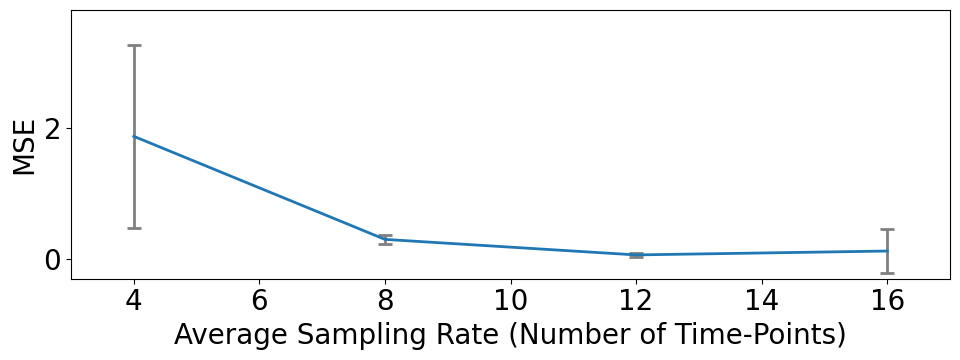

In [12]:
fig, ax = plt.subplots(figsize=(10,4))
df.plot(y='mean', yerr='ci',label='Mean',ax=ax, ecolor='gray', lw=2, capsize=5, capthick=2,legend=False)
ax.set_xlabel(r'Average Sampling Rate (Number of Time-Points)')
ax.set_ylabel('MSE')
ax.set_ylim([-0.3,3.8])
ax.set_xlim([3,17])
#ax.hlines(0,3,17,colors='gray',linestyle='dashed')
#ax.grid(True)
fig.tight_layout()
os.makedirs('figures', exist_ok=True)
fig.savefig('figures/sampling_rate_impact.pdf')